In [54]:
import pandas as pd
import numpy as np

# import file
df = pd.read_csv('../../res/tp2/german_credit.csv', sep=',') # columns: admit, gre, gpa, rank; 399 rows
#df = df[['Creditability', 'Account Balance', 'Duration of Credit (month)', 'Credit Amount', 'Age (years)']]

In [55]:
all_attrs = set(df)
all_attrs.remove('Creditability')

continuous_attrs = {'Duration of Credit (month)': ['<= 12', '<= 24', '<= 36', '<= 48', '<= 60', '> 60'],
                    'Credit Amount': ['<= 1000', '<= 2000', '<= 3000', '<= 4000', '<= 5000', '<= 6000', '<= 7000', '<= 8000',
                                      '<= 9000', '<= 10000', '<= 12000', '<= 14000', '> 14000'],
                    'Age (years)': ['< 30', '< 60', '>= 60']}
discrete_attrs = dict(map(lambda attr_name: (attr_name, list(df[attr_name].unique())),
                          filter(lambda attr_name: attr_name not in continuous_attrs, all_attrs)
                         ))
print(all_attrs)
print(list(discrete_attrs.keys()))

{'Account Balance', 'Occupation', 'Duration in Current address', 'Guarantors', 'Instalment per cent', 'Telephone', 'Payment Status of Previous Credit', 'Credit Amount', 'Duration of Credit (month)', 'Foreign Worker', 'Sex & Marital Status', 'No of Credits at this Bank', 'Purpose', 'No of dependents', 'Age (years)', 'Most valuable available asset', 'Length of current employment', 'Value Savings/Stocks', 'Concurrent Credits', 'Type of apartment'}
['Account Balance', 'Occupation', 'Duration in Current address', 'Guarantors', 'Instalment per cent', 'Telephone', 'Payment Status of Previous Credit', 'Foreign Worker', 'Sex & Marital Status', 'No of Credits at this Bank', 'Purpose', 'No of dependents', 'Most valuable available asset', 'Length of current employment', 'Value Savings/Stocks', 'Concurrent Credits', 'Type of apartment']


In [56]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)

test.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
295,1,4,36,2,1,8133,1,3,1,2,...,2,2,30,1,2,1,3,1,1,1
574,1,2,36,2,1,6948,1,3,2,3,...,2,3,35,3,1,1,4,1,2,1
407,1,2,9,2,9,1391,1,3,2,4,...,1,1,27,1,2,1,3,1,2,1
753,0,2,24,2,1,4113,3,2,3,2,...,4,3,28,3,1,1,3,1,1,1
371,1,4,24,4,3,2578,4,5,2,3,...,2,3,34,3,2,1,3,1,1,1


In [57]:
import math

global entropy
entropy = None
positive_creditability = 'Creditability == 1'

def format_query_string(attr, value, index=-1):
    if attr in continuous_attrs:
        return f'not (`{attr}` {continuous_attrs[attr][index-1]}) and `{attr}` {value}' if index > 0 else f'`{attr}` {value}'
    
    return f'`{attr}` == {value}'

def get_entropy_term(p):
    return - p * math.log2(p) if not math.isclose(p, 0) else 0

def get_entropy(data, cond=positive_creditability): # H(S)
    positive_freq = len(data.query(cond)) / len(data) if len(data) != 0 else 0
    negative_freq = 1 - positive_freq if len(data) != 0 else 0
    entropy = get_entropy_term(positive_freq) + get_entropy_term(negative_freq)
    
    return entropy

def get_attr_entropy(data, cond): # H(Sv)
    positive_freq = len(data.query(cond)) / len(data) if len(data) != 0 else 0
    negative_freq = 1 - positive_freq if len(data) != 0 else 0
    return get_entropy_term(positive_freq) + get_entropy_term(negative_freq)

def get_rows_by_attr_cond(data, attr, cond, cond_index):
    rows = None
    
    if cond_index == 0:
        rows = data.query(f'`{attr}` {cond}')
    else:
        prev_cond = continuous_attrs[attr][cond_index-1]
        rows = data.query(f'not(`{attr}` {prev_cond}) and `{attr}` {cond}')
        
    return rows
    
def gain(data, attr, class_cond=positive_creditability):
    ret = get_entropy(data)
    
    if attr in continuous_attrs:
        for i, cond in enumerate(continuous_attrs[attr]):
            rows = get_rows_by_attr_cond(data, attr, cond, i)
            ret -= len(rows) / len(data) * get_attr_entropy(rows, class_cond)
            # print(f'{attr}: {ret}')
    else:
        for value in discrete_attrs[attr]: # TODO FIX: PREGUNTAR SI VALOR DE ATRIBUTO NO APARECE EN TRAIN, FALLA
            rows = data.query(f'`{attr}` == {value}')
            ret -= len(rows) / len(data) * get_attr_entropy(rows, class_cond)
            # print(f'{attr},{value}: {ret}')
    
    return ret

gains = {}
for attr in train.columns:
    if attr == 'Creditability':
        continue
    gains[attr] = gain(train, attr)

print(gains)

#df['Credit Amount'].hist(grid=True, bins=30, rwidth=0.9, color='#607c8e')
#print(get_entropy(train, train.Creditability == 1))

{'Account Balance': 0.09869688209199066, 'Duration of Credit (month)': 0.023890513232009393, 'Payment Status of Previous Credit': 0.03985667645364256, 'Purpose': 0.029263067270001504, 'Credit Amount': 0.022486353209709674, 'Value Savings/Stocks': 0.030145549278405372, 'Length of current employment': 0.022824440898759263, 'Instalment per cent': 0.0069711256351252665, 'Sex & Marital Status': 0.007472035762297359, 'Guarantors': 0.006386575771357143, 'Duration in Current address': 0.001160145024326778, 'Most valuable available asset': 0.016671080146309525, 'Age (years)': 0.00721657012816232, 'Concurrent Credits': 0.00755000156612215, 'Type of apartment': 0.014261309384973136, 'No of Credits at this Bank': 0.0030902014984480483, 'Occupation': 0.0013328609669822633, 'No of dependents': 6.685933706673808e-08, 'Telephone': 0.0013456004455201787, 'Foreign Worker': 0.007741439107032282}


In [58]:
from tree import Tree, NodeType
import pdb

def get_max_gain(gains):
    max_attr = None
    max_gain = -1
    for attr, gain in gains.items():
        if gain > max_gain:
            max_gain = gain
            max_attr = attr
    return max_attr, max_gain

used_attrs = set({})

def add_level(data, current_level_attr, node=None):
    global used_attrs
    
    tree = None
    current_level_attr_node = None
    if node is None:
        tree = Tree()
        tree.root = current_level_attr_node = Tree.Node(NodeType.attr, current_level_attr)
    else:
        current_level_attr_node = node.add_child(NodeType.attr, current_level_attr)
    
    used_attrs.add(current_level_attr)
    
    values = continuous_attrs[current_level_attr] if current_level_attr in continuous_attrs else discrete_attrs[current_level_attr]
    for i, val in enumerate(values):
        
        if tree is not None:
            print(f'Processing value {val} for root attribute {tree.root.value}...')
        
        current_level_attr_value_node = current_level_attr_node.add_child(NodeType.val, val)
        rows = data.query(format_query_string(current_level_attr, val, i))
        
        if (len(rows) == 0):
            current_level_attr_value_node.add_child(NodeType.leaf, data['Creditability'].mode()[0])
            continue
        
        classes = rows['Creditability'].unique()
        if len(classes) == 1:  # Only positive or negative examples left (leaf)
            current_level_attr_value_node.add_child(NodeType.leaf, classes[0])
            continue
        else:
            selected_attrs = set(data) - set(['Creditability'])
            unprocessed_attrs = selected_attrs - used_attrs # Selected dataset columns - Used columns
            if len(unprocessed_attrs) == 0:  # No more attributes to calculate gain for (leaf)
                current_level_attr_value_node.add_child(NodeType.leaf, rows['Creditability'].mode()[0])  # The most frequent value for Creditability
            else:
                current_gains = {}
                for attr in unprocessed_attrs:
                    current_gains[attr] = gain(rows, attr)
                next_level_attr, _ = get_max_gain(current_gains)
                # print(current_gains)
                if (next_level_attr is None):
                    raise Exception(f'Invalid state: gains returned attribute None - {current_gains}')
                else:
                    add_level(rows, next_level_attr, current_level_attr_value_node)
    
    used_attrs.remove(current_level_attr)
    
    if tree:
        used_attrs.clear()
        return tree


#tr = Tree(root_attr)
#add_level(train, root_attr, tr.root)
#print('\n\n\n\n\n**********************************\n\n\n')
#print(tr)

In [59]:
def evaluate_condition(attr, asked_value, tree_cond): # attr = Age, asked_value = 28, tree_cond = '<= 30'
    if attr in continuous_attrs:
        index = continuous_attrs[attr].index(tree_cond)
        return eval(f'not ({asked_value} {continuous_attrs[attr][index-1]}) and {asked_value} {tree_cond}' if index > 0 else f'{asked_value} {tree_cond}')
        
    return asked_value == tree_cond

def classify(row, tree, stdout=False):
    current_node = tree.root
    current_node_type = NodeType.attr
    
    while(current_node.children):
        current_node_val = current_node.value
        current_node_type = current_node.node_type
        if stdout:
            print(f'Node value: {current_node_val} - Type: {current_node_type}')
        
        if current_node_type == NodeType.attr:
            row_val = row[current_node_val]
            found_value = False
            for child in current_node.children:
                # print(f'Attr {current_node_val} Child Value: {child.value}')
                if evaluate_condition(current_node_val, row_val, child.value):
                    current_node = child
                    found_value = True
                    break
            if not found_value:
                raise Exception('Could not find attribute value')
        elif current_node_type == NodeType.val:
            current_node = current_node.children[0]
        else:
            raise Exception('Invalid State')
    
    if stdout:
        print(f'\nNode value: {current_node.value} - Type: {current_node_type}\n')
    return current_node.value

def build_tree(data, stdout=False):
    root_gains = {}
    for attr in data.columns:
        if attr == 'Creditability':
            continue
        root_gains[attr] = gain(data, attr)
    
    root_attr, _ = get_max_gain(root_gains)
    if (root_attr is None):
        raise Exception(f'Invalid state: gains returned attribute None - {root_gains}')
    
    tree = add_level(data, root_attr)
    if stdout:
        print(tree)
    return tree

# print(test.iloc[0])
# classify(test.iloc[0], tree)

In [61]:
import statistics as stats
from random import sample

# Bagging - Random forest
def build_forest(data, sample_fraction=0.4, iterations=3, column_sample_size=len(all_attrs)):
    forest = []
    selected_columns = list(all_attrs)
    selected_columns.append('Creditability')
    
    while iterations > 0:
        print(f'Remaining trees: {iterations}')
        
        if column_sample_size != len(all_attrs):
            selected_columns = sample(all_attrs, column_sample_size)
            if creditability not in selected_columns:
                selected_columns.append('Creditability')
            
        subset = data.sample(frac=sample_fraction, replace=True, axis=0)
        t = build_tree(subset[selected_columns])
        forest.append(t)
        iterations -= 1
        
        #print(f'\n\n\n\n\n\n\n\n************STARTING TREE************\n\n\n\n\n\n\n\n{t}')
        
    print('Done\n')
    return forest

def classify_random_forest(row, data=train, forest=None, stdout=False):
    if forest is None:
        forest = build_forest(data)
    classifications = []
    for tree in forest:
        classifications.append(classify(row, tree, stdout))
    if stdout:
        print(classifications)
    return stats.mode(classifications)

In [62]:
row = test.iloc[0]
print(row)
print(classify_random_forest(row, stdout=True))

Creditability                           1
Account Balance                         4
Duration of Credit (month)             36
Payment Status of Previous Credit       2
Purpose                                 1
Credit Amount                        8133
Value Savings/Stocks                    1
Length of current employment            3
Instalment per cent                     1
Sex & Marital Status                    2
Guarantors                              1
Duration in Current address             2
Most valuable available asset           2
Age (years)                            30
Concurrent Credits                      1
Type of apartment                       2
No of Credits at this Bank              1
Occupation                              3
No of dependents                        1
Telephone                               1
Foreign Worker                          1
Name: 295, dtype: int64
Remaining trees: 3
Processing value 1 for root attribute Account Balance...
Processing value 2

Remaining trees: 9
Processing value 1 for root attribute Account Balance...
Processing value 2 for root attribute Account Balance...
Processing value 4 for root attribute Account Balance...
Processing value 3 for root attribute Account Balance...
Remaining trees: 8
Processing value 1 for root attribute Account Balance...
Processing value 2 for root attribute Account Balance...
Processing value 4 for root attribute Account Balance...
Processing value 3 for root attribute Account Balance...
Remaining trees: 7
Processing value 1 for root attribute Account Balance...
Processing value 2 for root attribute Account Balance...
Processing value 4 for root attribute Account Balance...
Processing value 3 for root attribute Account Balance...
Remaining trees: 6
Processing value 1 for root attribute Account Balance...
Processing value 2 for root attribute Account Balance...
Processing value 4 for root attribute Account Balance...
Processing value 3 for root attribute Account Balance...
Remaining tr

<AxesSubplot:>

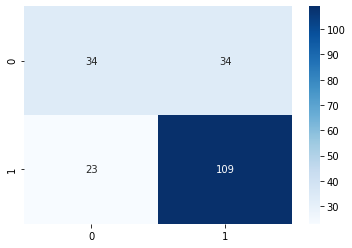

In [63]:
import seaborn as sns

# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 } # {0: {0: 700, 1: 1048}, 1: {...}}

forest = build_forest(train, sample_fraction=0.6, iterations=9)
for i in range(len(test)):
    row = test.iloc[i]
    creditability = row['Creditability']
    
    result = classify_random_forest(row, forest=forest)
    confusion_matrix[creditability][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [64]:
print(test['Creditability'].value_counts())

1    132
0     68
Name: Creditability, dtype: int64


In [ ]:
#def plot_precision_figure(data):
#    column_count = len(all_attrs)
#    for i in range(1, column_count + 1):
#        forest = build_forest(..., 3)